In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import torch
from IPython.display import display
from eodhd import APIClient
from stable_baselines3.common.vec_env import DummyVecEnv

from Env.StockTradingEnv import StockTradingEnv
from Env.Agents import EnsembleAgent, PPOAgent, A2CAgent, DDPGAgent, SACAgent, TD3Agent

In [2]:
print(torch.cuda.is_available())  # Should return True if GPU is detected
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.current_device())  # Index of the current GPU
print(torch.cuda.get_device_name(0))  # Name of the first GPU

True
1
0
NVIDIA GeForce RTX 2070 with Max-Q Design


Download the stocks data

In [3]:
api_key = os.getenv('EODHD_API_KEY')
api = APIClient(api_key)

In [4]:
n_years = 1
up_to_year = 2024
train_split = 0.9

n_years_train = n_years // (1 / train_split) + 1

init_year_train = int(up_to_year - n_years)
init_year_valid = int(init_year_train + n_years_train)

init_date_train = datetime(init_year_train, 1, 1)
init_date_valid = datetime(init_year_valid, 1, 1) 

end_date_train = datetime(init_year_valid-1, 12, 31)
current_year = datetime.now().year
end_date_valid = datetime.now() if up_to_year == current_year else datetime(up_to_year, 12, 31)

init_date_train, end_date_train, init_date_valid, end_date_valid


(datetime.datetime(2023, 1, 1, 0, 0),
 datetime.datetime(2023, 12, 31, 0, 0),
 datetime.datetime(2024, 1, 1, 0, 0),
 datetime.datetime(2024, 12, 31, 0, 0))

In [5]:
# List of tickers
tickers = ['NVDA', 'BABA', 'KO']

In [6]:
# def get_ticker_data(ticker):
#     data = api.get_eod_historical_stock_market_data(symbol = ticker, 
#                                                     period='d', 
#                                                     from_date = init_date_train - timedelta(days= 30), # additional days for technical indicators calculations
#                                                     to_date = end_date_test, 
#                                                     order='a')
#     return pd.DataFrame(data)

In [7]:
# def create_tickers():
#     for ticker in tickers:
#         try:
#             # Fetch data for the ticker
#             df = get_ticker_data(ticker)
            
#             # Save data to a CSV file
#             file_name = os.path.join('Tickers CSV', f"{ticker}.csv")
#             df.to_csv(file_name, index=False)
            
#             print(f"Data for {ticker} saved to {file_name}")
#         except Exception as e:
#             print(f"Error fetching data for {ticker}: {e}")

# create_tickers()

Adjust Dataframes format and add Techinical indicators

In [8]:
# Get the data from the CSV files
stock_data = {}
for ticker in tickers:
    df = (
    pd.read_csv(os.path.join('Tickers CSV', f"{ticker}.csv"), parse_dates=True)
    .rename(columns=str.title)  # Capitalize the first letter of all column names
    )

    # Drop all columns named 'Close'
    df = df.drop(columns=['Close'], errors='ignore')  # Errors='ignore' ensures no issues if 'Close' doesn't exist

    # Rename 'Adjusted_Close' to 'Close'
    if 'Adjusted_Close' in df.columns:
        df.rename(columns={'Adjusted_Close': 'Close'}, inplace=True)

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Add 'return' column based on the newly renamed 'Close'
    df['Return'] = df['Close'].pct_change()

    # Store the modified DataFrame in the dictionary
    stock_data[ticker] = df


In [9]:
def add_technical_indicators(df):
    """
    Add common technical indicators to the stock data DataFrame.
    
    Parameters:
    df (DataFrame): A DataFrame containing stock price data with columns 'Open', 'High', 'Low', 'Close', and 'Volume'.
    
    Returns:
    DataFrame: The original DataFrame with additional columns for RSI, MACD, Signal, CCI, and ADX.
    """

    # Calculate Relative Strength Index (RSI) over a 14-period window
    # RSI measures the strength of price changes (upward or downward) and provides values between 0 and 100.
    # It indicates whether an asset is overbought or oversold.
    delta = df['Close'].diff()  # Calculate the difference between consecutive closing prices
    up = delta.where(delta > 0, 0)  # Keep positive changes (upward movements), set others to 0
    down = -delta.where(delta < 0, 0)  # Keep negative changes (downward movements), set others to 0 and make them positive
    rs = up.rolling(window=14).mean() / down.rolling(window=14).mean()  # Compute the relative strength
    df['RSI'] = 100 - (100 / (1 + rs))  # Calculate the RSI based on relative strength

    # Calculate Exponential Moving Averages (EMA) for MACD
    # MACD (Moving Average Convergence Divergence) is used to identify trend direction and momentum.
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()  # 12-period EMA
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()  # 26-period EMA
    df['MACD'] = df['EMA12'] - df['EMA26']  # The MACD line is the difference between EMA12 and EMA26
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()  # Signal line (9-period EMA of MACD)

    # Calculate Commodity Channel Index (CCI) over a 20-period window
    # CCI measures the deviation of the asset's price from its average price over a certain period.
    tp = (df['High'] + df['Low'] + df['Close']) / 3  # Typical Price (TP): average of high, low, and close prices
    sma_tp = tp.rolling(window=20).mean()  # Simple Moving Average (SMA) of Typical Price over 20 periods
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))  # Mean absolute deviation
    df['CCI'] = (tp - sma_tp) / (0.015 * mean_dev)  # CCI formula: (TP - SMA_TP) / (0.015 * Mean Dev)

    # Calculate Average Directional Index (ADX) over a 14-period window
    # ADX measures the strength of a trend (ranging from 0 to 100).
    high_diff = df['High'].diff()  # Difference between current and previous high prices
    low_diff = df['Low'].diff()  # Difference between current and previous low prices
    df['+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)  # Positive directional movement (+DM)
    df['-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)  # Negative directional movement (-DM)
    tr = pd.concat([
        df['High'] - df['Low'],  # High minus Low
        np.abs(df['High'] - df['Close'].shift(1)),  # Absolute difference between current high and previous close
        np.abs(df['Low'] - df['Close'].shift(1))  # Absolute difference between current low and previous close
    ], axis=1).max(axis=1)  # True Range (TR): max of the above values
    atr = tr.ewm(span=14, adjust=False).mean()  # Average True Range (ATR) over 14 periods
    df['+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)  # Positive Directional Indicator (+DI)
    df['-DI'] = 100 * (df['-DM'].ewm(span=14, adjust=False).mean() / atr)  # Negative Directional Indicator (-DI)
    dx = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])  # Directional Movement Index (DX)
    df['ADX'] = dx.ewm(span=14, adjust=False).mean()  # Average DX over 14 periods (ADX)

    # Drop rows with NaN values caused by rolling calculations
    df.dropna(inplace=True)

    # Keep only relevant columns for analysis
    df = df[['Open', 'High', 'Low', 'Close', 'Return', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX']]

    return df


In [10]:
# add technical indicators to the training data for each stock
for ticker, df in stock_data.items():
    stock_data[ticker] = add_technical_indicators(df)

In [11]:
stock_data[ticker]

,Open,High,Low,Close,Return,Volume,MACD,Signal,RSI,CCI,ADX
Date,,,,,,,,,,,
2003-12-30,50.00000000,50.83000000,49.96000000,13.39400000,0.00718126,7118600,0.21159827,0.19640757,78.87012782,79.67458299,26.06812483
2003-12-31,50.52000000,50.81000000,50.40000000,13.45500000,0.00455428,6974600,0.21617734,0.20036152,77.94795784,85.17556839,24.29423346
2004-01-02,50.80000000,50.99000000,50.01000000,13.34890000,-0.00788554,7210200,0.20883755,0.20205673,70.49865867,72.47550718,23.69665490
2004-01-05,50.35000000,50.59000000,50.06000000,13.36480000,0.00119111,9740200,0.20197547,0.20204048,63.46849047,60.28996725,22.77549811
2004-01-06,50.22000000,50.37000000,50.12000000,13.30910000,-0.00416766,8223200,0.18985417,0.19960322,55.61524951,51.47138033,21.45128351
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,62.20000000,62.84000000,62.01000000,62.37970000,0.00737529,5019100,-0.39736981,-0.46898630,54.65271991,-69.09122375,68.27132253
2024-12-26,62.62000000,62.74000000,62.40000000,62.11160000,-0.00429787,7943800,-0.38754552,-0.45269814,47.23508537,-63.59469965,71.10159777
2024-12-27,62.45000000,62.95000000,62.21000000,61.99250000,-0.00191752,8542800,-0.38493280,-0.43914507,49.34009309,-65.17001357,70.36001722


In [12]:
# split the data into training, validation and test sets
training_data = {}
validation_data = {}

for ticker, df in stock_data.items():
    training_data[ticker] = df.loc[init_date_train : end_date_train]
    validation_data[ticker] = df.loc[init_date_valid : end_date_valid]

In [13]:
print(f'Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'Validation data shape for {ticker}: {validation_data[ticker].shape}')

Training data shape for KO: (250, 11)
Validation data shape for KO: (252, 11)


In [14]:
training_data[ticker]

,Open,High,Low,Close,Return,Volume,MACD,Signal,RSI,CCI,ADX
Date,,,,,,,,,,,
2023-01-03,63.56000000,63.56000000,62.18000000,58.78240000,-0.01037565,12180500,0.48363548,0.65037192,41.14705336,-120.63798055,14.24560592
2023-01-04,63.15000000,63.33000000,62.51000000,58.75440000,-0.00047633,13387900,0.40697662,0.60169286,40.72898688,-99.59774138,16.14307672
2023-01-05,62.60000000,62.80000000,62.08000000,58.08200000,-0.01144425,9814700,0.28863961,0.53908221,36.21033874,-163.79507926,17.78755141
2023-01-06,62.91000000,63.67000000,62.58000000,59.20260000,0.01929341,9990000,0.28202867,0.48767150,52.12906472,-28.56662264,18.01405010
2023-01-09,63.30000000,63.72000000,62.58000000,58.46490000,-0.01246060,9442600,0.21478730,0.43309466,49.03344130,-58.84884590,18.46968824
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,58.12000000,58.46000000,58.02000000,56.17700000,0.00568930,9028500,0.34270495,0.54042782,47.77088924,-67.21530240,29.10832963
2023-12-26,58.06000000,58.71000000,58.06000000,56.40820000,0.00411556,6422500,0.32249007,0.49684027,49.13213533,-35.23934470,29.42551975
2023-12-27,58.64000000,58.77000000,58.40000000,56.55270000,0.00256168,8560100,0.31450417,0.46037305,50.93967950,-1.37967231,31.35988791


In [15]:
[(list(training_data.keys())[i], len(df)) for i, df in enumerate(training_data.values())]

[('NVDA', 250), ('BABA', 250), ('KO', 250)]

In [16]:
max_len_stock_train = max(len(df) for df in training_data.values())
max_len_stock_train

250

In [17]:
[(list(validation_data.keys())[i], len(df)) for i, df in enumerate(validation_data.values())]

[('NVDA', 252), ('BABA', 252), ('KO', 252)]

In [18]:
max_len_stock_valid = max(len(df) for df in validation_data.values())
max_len_stock_valid

252

Train Model

In [19]:
# Function to create the environment and train multiple agents
def create_env_and_train_agents(train_data, total_timesteps, log_file):
    """
    Create a trading environment and train agents using different reinforcement learning algorithms.

    Parameters:
    - train_data: The dataset containing stock trading data, used to simulate the trading environment.
    - total_timesteps: The number of timesteps (or iterations) to train each agent.

    Returns:
    - env: The trading environment created for the agents.
    - ppo_agent: The trained PPOAgent instance.
    - a2c_agent: The trained A2CAgent instance.
    - ddpg_agent: The trained DDPGAgent instance.
    - ensemble_agent: The trained EnsembleAgent instance that combines all the individual agents.
    """

    # Step 1: Create the stock trading environment
    # `DummyVecEnv` wraps the environment for compatibility with stable-baselines models.
    # It allows vectorized environments, but here it uses a single instance of `StockTradingEnv`. Why vectorize?:
    # Ensures compatibility with RL algorithms. Makes scaling to multiple environments easier. Provides automatic handling of episode resets and batched inputs.
    # A vectorized environment allows to apply additional methods, as:
    # - get_attr and set_attr to retrieve or modify specific attributes in the environment.
    # - env_method to call custom methods defined in the environment.
    # - reset, step, and close to handle the lifecycle of the environment during training or testing.
    train_env = DummyVecEnv([lambda: StockTradingEnv(training_data)])

    # Train PPO Agent
    print('Training Agent: PPO')
    ppo_agent = PPOAgent(train_env, total_timesteps)

    # Train A2C Agent
    print('Training Agent: A2C')
    a2c_agent = A2CAgent(train_env, total_timesteps)

    # Train DDPG Agent
    print('Training Agent: DDPG')
    ddpg_agent = DDPGAgent(train_env, total_timesteps)

    # Train SAC Agent
    print('Training Agent: SAC')
    sac_agent = SACAgent(train_env, total_timesteps)

    # Train TD3 Agent
    print('Training Agent: TD3')
    td3_agent = TD3Agent(train_env, total_timesteps)

    # Train the ensemble agent
    print('Training Agent: Ensemble')
    ensemble_agent = EnsembleAgent(ppo_agent.model, a2c_agent.model, ddpg_agent.model, sac_agent.model, td3_agent.model)

    return train_env, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent


Visualizations

In [20]:
# Function to visualize portfolio changes
def visualize_portfolio(steps, balances, net_worths, shares_held, tickers, show_balance=True, show_net_worth=True, show_shares_held=True):
    fig, axs = plt.subplots(3, figsize=(12, 18))

    # Plot the balance
    if show_balance:
        axs[0].plot(steps, balances, label='Balance')
        axs[0].set_title('Balance Over Time')
        axs[0].set_xlabel('Steps')
        axs[0].set_ylabel('Balance')
        axs[0].legend()

    # Plot the net worth
    if show_net_worth:
        axs[1].plot(steps, net_worths, label='Net Worth', color='orange')
        axs[1].set_title('Net Worth Over Time')
        axs[1].set_xlabel('Steps')
        axs[1].set_ylabel('Net Worth')
        axs[1].legend()

    # Plot the shares held
    if show_shares_held:
        for ticker in tickers:
            axs[2].plot(steps, shares_held[ticker], label=f'Shares Value: {ticker}')
        axs[2].set_title('Shares Held Over Time')
        axs[2].set_xlabel('Steps')
        axs[2].set_ylabel('Shares Held')
        axs[2].legend()

    plt.tight_layout()
    plt.show()



In [21]:
# function to visualize the portfolio net worth
def visualize_portfolio_net_worth(steps, net_worths):
    plt.figure(figsize=(12, 6))
    plt.plot(steps, net_worths, label='Net Worth', color='orange')
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()



In [22]:
# function to visualize the multiple portfolio net worths ( same chart )
def visualize_multiple_portfolio_net_worth(steps, net_worths_list, labels):
    plt.figure(figsize=(12, 6))
    for i, net_worths in enumerate(net_worths_list):
        plt.plot(steps, net_worths, label=labels[i])
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

In [23]:
def test_agent(test_env, agent, agent_name, test_data, n_tests=1000, logs=True):
    """
    Test a single agent in the trading environment, track performance metrics, and optionally visualize results.

    Parameters:
    - test_env: The stock trading environment where the agent will operate.
    - agent: The trained agent to be tested.
    - test_data (dict): The dataset containing information about stocks in the environment.
    - n_tests (int): The number of test runs to execute (default: 1000).
    - logs (bool): Whether to render the environment during testing (default: True).

    Returns:
    - metrics (dict): A dictionary containing performance metrics, such as:
        - steps: List of steps/timesteps for each test.
        - balances: List of the agent's balance after each step.
        - net_worths: List of the agent's net worth after each step.
        - shares_held: Dictionary tracking of shares held for each stock.
    """

    # Step 1: Initialize the metrics dictionary to track performance over all tests
    metrics = {
        'steps': [],  # Tracks the timestep number for each test
        'balances': [],  # Tracks the balance of the agent at each step
        'net_worths': [],  # Tracks the net worth of the agent at each step
        'shares_held': {ticker: [] for ticker in test_data.keys()}  # Tracks shares value for each stock
    }

    # Step 2: Reset the environment to its initial state before starting the tests
    obs = test_env.reset()

    # Step 3: Run the testing loop for the specified number of test runs (n_tests)
    for i in range(n_tests):
        # Track the current test step
        metrics['steps'].append(i)

        # Step 3.1: Use the trained agent to predict an action based on the current observation
        action = agent.predict(obs)

        # Step 3.2: Execute the predicted action in the environment and get feedback
        # The environment returns:
        # - obs: The next observation (state).
        # - rewards: The reward received for the action.
        # - dones: Boolean indicating if the episode has ended.
        # - infos: Additional diagnostic information (containing the 'truncated' info).
        # Handle environments that return either 5 or 4 values
        step_result = test_env.step(action)
        if len(step_result) == 4:  # 4 is the expected length, with the 'infos' field containing the 'truncated' information
            obs, rewards, dones, infos = step_result
            truncated = infos[0]['TimeLimit.truncated']
        else:
            obs, rewards, dones, truncated, infos = step_result

        # Step 3.3: Render the environment if visualization is enabled
        if logs:
            test_env.envs[0].render(agent_name = agent_name)

        # Step 4: Track performance metrics
        # - Append the current balance of the agent
        metrics['balances'].append(test_env.get_attr('balance')[0])

        # - Append the current net worth of the agent (balance + value of held shares)
        metrics['net_worths'].append(test_env.get_attr('net_worth')[0])

        # - Get the current shares held by the agent (dictionary of stock tickers and their quantities)
        env_shares_held = test_env.get_attr('shares_held')[0]

        # - Update shares held for each stock ticker
        for ticker in test_data.keys():
            if ticker in env_shares_held:
                metrics['shares_held'][ticker].append(env_shares_held[ticker])  # Add quantity if ticker is tracked
            else:
                metrics['shares_held'][ticker].append(0)  # If ticker is missing, append 0 (no shares held)

        # Step 5: Check if the episode has ended (done = True)
        # If the episode is done, reset the environment to restart for the next test run
        # if dones:
        #     obs = test_env.reset()

    # Step 6: Return the collected metrics after testing
    return metrics


In [24]:
def test_and_visualize_agents(test_env, agents, test_data, n_tests=1000):
    """
    Test and visualize the performance of multiple agents, including the Ensemble Agent.
    
    Parameters:
    - test_env: The trading environment where the agents will be tested.
    - agents (dict): A dictionary of agents to test, with keys as agent names (e.g., 'PPO', 'A2C') and 
      values as the respective agent objects.
    - test_data (dict): The stock trading dataset used in the environment.
    - n_tests (int): The number of test episodes to run for each agent (default: 1000).

    This function runs the specified number of tests for each agent, collects performance metrics, and
    visualizes the results.
    """

    # Initialize an empty dictionary to store performance metrics for each agent
    metrics = {}

    # Iterate through each agent in the provided dictionary
    for agent_name, agent in agents.items():
        # Print a message to indicate testing is starting for the current agent
        print(f"Testing {agent_name}...")

        # - Collects metrics such as balance, net worth, and shares held over the test episodes
        metrics[agent_name] = test_agent(test_env, agent, agent_name, test_data, n_tests)
        
        # Print a message to indicate testing is complete for the current agent
        print(f"Done testing {agent_name}!")

    # Print a separator to signal that all testing is complete
    print('-' * 50)
    print('All agents tested!')
    print('-' * 50)

    # Step 1: Extract the net worth data for all agents
    # - For each agent, retrieve the 'net_worths' metric from the stored metrics dictionary.
    # - This will be used for visualization to compare the financial performance of the agents.
    net_worths = [metrics[agent_name]['net_worths'] for agent_name in agents.keys()]

    # Step 2: Extract the step data (timesteps) for plotting
    # - Retrieve the 'steps' metric from the metrics dictionary.
    steps = next(iter(metrics.values()))['steps']

    # Step 3: Visualize the portfolio net worth over time for all agents
    # - The visualization function takes the steps (timesteps), net worths, and agent names to plot a graph.
    # - This provides a visual comparison of how each agent's portfolio value evolved during the tests.
    visualize_multiple_portfolio_net_worth(steps, net_worths, list(agents.keys()))

    return metrics


In [25]:
def compare_and_plot_agents(agents_metrics, labels):
    """
    Compare the performance of multiple agents using returns, standard deviation, 
    and Sharpe ratio, and visualize the results.

    Parameters:
    - agents_metrics (list): A list of dictionaries containing metrics for each agent. 
                              Each dictionary should include 'net_worths', which represents
                              the net worth over time for the agent.
    - labels (list): A list of labels (agent names) corresponding to the metrics provided.

    This function calculates the performance metrics (returns, standard deviation, and Sharpe ratio)
    for each agent, sorts them by Sharpe ratio, displays the results in a dataframe, and 
    plots a bar chart comparing Sharpe ratios.
    """

    # Step 1: Define a helper function to compute performance metrics
    def compare_agents(agents_metrics, labels):
        """
        Compute average returns, standard deviation, and Sharpe ratio for each agent.

        Parameters:
        - agents_metrics (list): A list of dictionaries containing 'net_worths' for each agent.
        - labels (list): A list of agent names corresponding to the metrics provided.

        Returns:
        - df (DataFrame): A pandas DataFrame containing the metrics for all agents.
        """
        # Initialize lists to store performance metrics for each agent
        returns = []  # Average returns (mean of net worths)
        stds = []  # Standard deviation of net worths
        sharpe_ratios = []  # Sharpe ratio (return / standard deviation)

        # Iterate through each agent's metrics
        for metrics in agents_metrics:
            # Calculate daily (or step-based) returns
            net_worths = metrics['net_worths']
            daily_returns = np.diff(net_worths) / net_worths[:-1]  # Percentage changes
        
            # Calculate mean return
            mean_return = np.mean(daily_returns)
        
            # Calculate standard deviation of returns
            std = np.std(daily_returns)
        
            # Risk-free rate (set to 0 if not provided)
            risk_free_rate = 0.0
        
            # Calculate Sharpe ratio
            sharpe_ratio = (mean_return - risk_free_rate) / std if std > 0 else 0
        
            # Append metrics
            returns.append(mean_return)
            stds.append(std)
            sharpe_ratios.append(sharpe_ratio)


        # Create a pandas DataFrame to organize the results
        df = pd.DataFrame({
            'Agent': labels,  # Agent names
            'Return': returns,  # Average returns
            'Standard Deviation': stds,  # Standard deviation of returns
            'Sharpe Ratio': sharpe_ratios  # Sharpe ratios
        })

        return df  # Return the performance metrics DataFrame

    # Step 2: Compute performance metrics for all agents
    df = compare_agents(agents_metrics, labels)

    # Step 3: Sort the agents by Sharpe ratio in descending order
    # - Agents with a higher Sharpe ratio are considered to have better risk-adjusted performance.
    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)

    # Step 4: Display the sorted metrics in a table
    # - This shows a clear comparison of returns, standard deviation, and Sharpe ratio for each agent.
    display(df_sorted)

    # Step 5: Plot a bar chart to compare Sharpe ratios across agents
    plt.figure(figsize=(12, 6))  # Set the figure size for better visibility
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'], color='skyblue')  # Create a bar chart
    plt.title('Sharpe Ratio Comparison')  # Add a title to the chart
    plt.xlabel('Agent')  # Label the x-axis
    plt.ylabel('Sharpe Ratio')  # Label the y-axis
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to fit the chart properly
    plt.show()  # Display the bar chart


TRAIN

In [26]:
current_date = datetime.now().strftime("%Y-%m-%d")  # Format as YYYY-MM-DD
total_timesteps = max_len_stock_train
n_tests = max_len_stock_valid

# Concatenate the current date with the modified variable names
log_file = f"Logs/{current_date}_ts{total_timesteps}_tests{n_tests}"

In [27]:
# 1. Create the environment and train the agents
env_train, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent = create_env_and_train_agents(training_data, total_timesteps, log_file=log_file)


Training Agent: PPO
Using cuda device


C:\Users\Alienware\miniconda3\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 334  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
Training Agent: A2C
Using cuda device


C:\Users\Alienware\miniconda3\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Training Agent: DDPG
Using cuda device
Training Agent: SAC
Using cuda device
Training Agent: TD3
Using cuda device
Training Agent: Ensemble


In [28]:
agents = {
    'PPO': ppo_agent,
    'A2C': a2c_agent,
    'DDPG': ddpg_agent,
    'SAC': sac_agent,
    'TD3': td3_agent,
    'Ensemble': ensemble_agent
}

Testing PPO...
Done testing PPO!
Testing A2C...
Done testing A2C!
Testing DDPG...
Done testing DDPG!
Testing SAC...
Done testing SAC!
Testing TD3...
Done testing TD3!
Testing Ensemble...
Done testing Ensemble!
--------------------------------------------------
All agents tested!
--------------------------------------------------


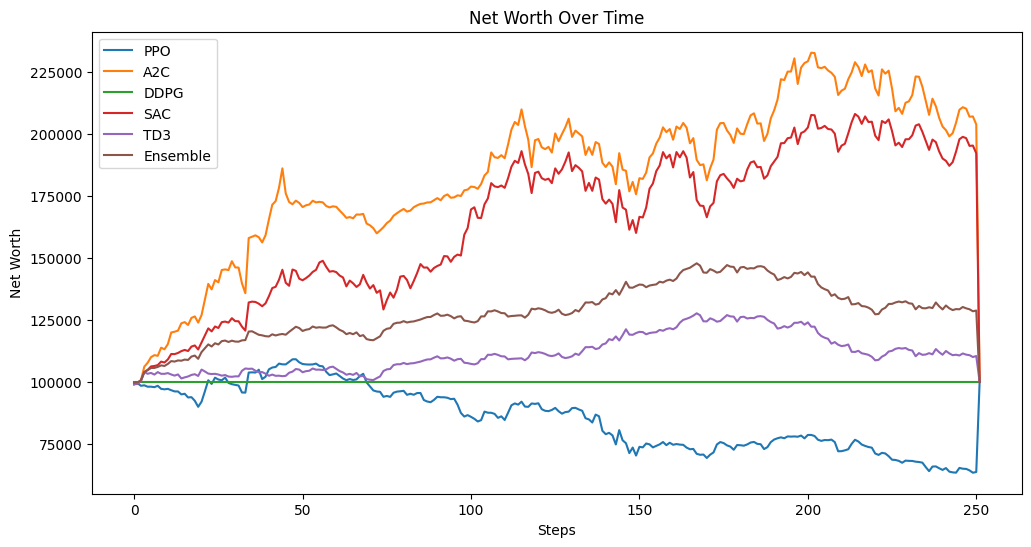

In [29]:
test_env = DummyVecEnv([lambda: StockTradingEnv(validation_data, render_mode='human', log_file=log_file)])

# 2. Test & visualize the agents
metrics = test_and_visualize_agents(test_env, agents, validation_data, n_tests=n_tests)


TEST

,Agent,Return,Standard Deviation,Sharpe Ratio
3,SAC,0.00095600,0.03699183,0.02584361
1,A2C,0.00081849,0.03564488,0.02296245
0,PPO,0.00020234,0.01636372,0.01236487
5,Ensemble,0.00019372,0.01766849,0.01096442
4,TD3,0.00009388,0.01025019,0.00915844
2,DDPG,0.00000000,0.00000000,0.00000000


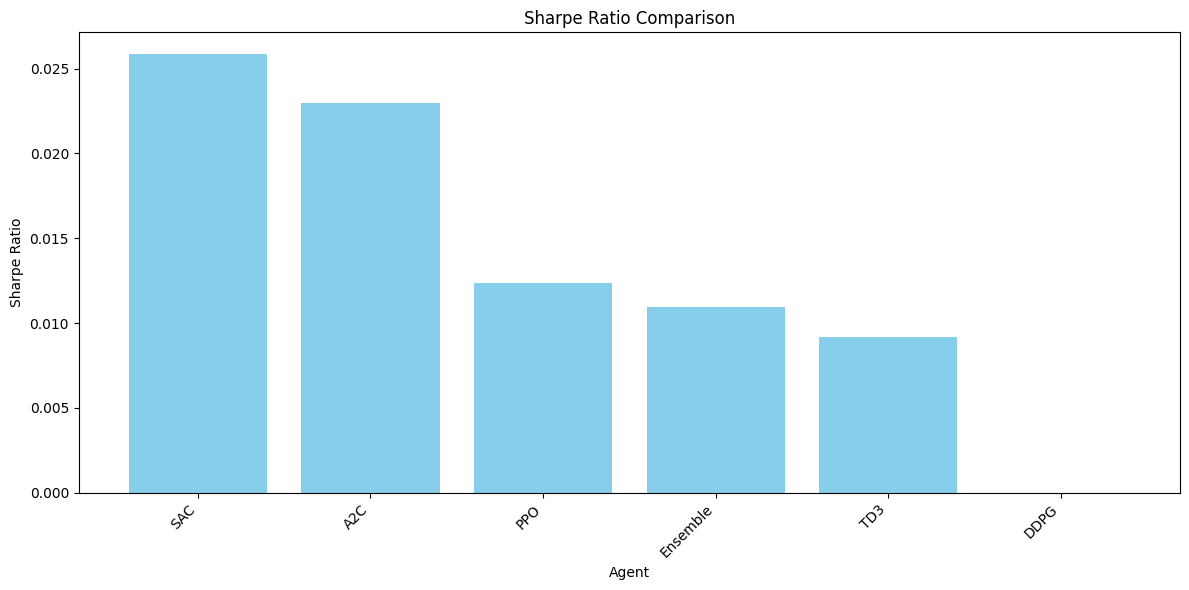

In [30]:
# 3. Compare the agents' performance ( returns, standard deviation, and sharpe ratio )
agents_metrics = [
    test_agent(test_env, agent, agent_name, validation_data, n_tests=n_tests, logs=False)
    for agent, agent_name in zip(agents.values(), agents.keys())
]

compare_and_plot_agents(agents_metrics, list(agents.keys()))

In [31]:
# metrics